# Chainerでクラス分類

# データの読み込み

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('wine-class.csv')

In [328]:
df.head()

,Class,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,1,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,1,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185
3,1,14.37,2.50,16.8,113,3.85,3.49,0.24,7.80,0.86,1480
4,1,13.24,2.87,21.0,118,2.80,2.69,0.39,4.32,1.04,735


# 入力変数と教師データ(出力変数)に切り分ける

In [329]:
t = df.iloc[:, 0] # [行、列]
t.head()

0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64

In [330]:
x = df.iloc[:, 1:]
x.head()

,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185
3,14.37,2.50,16.8,113,3.85,3.49,0.24,7.80,0.86,1480
4,13.24,2.87,21.0,118,2.80,2.69,0.39,4.32,1.04,735


In [331]:
type(x.values)

numpy.ndarray

In [332]:
t = t.values - 1 # 0スタートする
x = x.values

In [333]:
x = x.astype('f')
t = t.astype('i')

# ニューラルネットワークのモデルを定義

In [334]:
import chainer
import chainer.functions as F
import chainer.links as L

In [335]:
class NN(chainer.Chain):
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)
            
            # Batch Nomalization
            self.bn = L.BatchNormalization(10)
    
    # 順伝播
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        #h = F.sigmoid(h)
        h = self.fc2(h)
        return h

In [336]:
import numpy as np

In [337]:
np.random.seed(1)
nn = NN()
model = L.Classifier(nn)

# Chainerで使用するデータセットの形式

In [338]:
dataset = list(zip(x, t))

# 訓練データと検証データに分割

In [339]:
import chainer

In [340]:
len(dataset)

178

In [341]:
n_train = int(len(dataset) * 0.7)
n_train

124

In [342]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=1)

In [343]:
len(train)

124

In [344]:
len(test)

54

# 学習するための設定

# Optimizerの設定

In [345]:
optimizer = chainer.optimizers.SGD() # 確率的勾配降下法
#optimizer = chainer.optimizers.Adam() # 確率的勾配降下法

In [346]:
optimizer.setup(model)

# Iteratorの設定

In [347]:
batchsize = 10

In [348]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# Updaterの設定
- CPU: -1
- GPU: 0

In [349]:
from chainer import training

In [350]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

# TrainerとExtensionsの設定

In [351]:
from chainer.training import extensions

In [352]:
# エポックの数
epoch = 96

In [353]:
# trainerの宣言
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/wine')

# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
# 1 エポックごとにtrainデータに対するloss/accuracyとtestデータに対するloss/accuracy, 経過時間を出力
trainer.extend(extensions.PrintReport(['epoch', 
                                       'main/accuracy', 
                                       'validation/main/accuracy', 
                                       'main/loss', 
                                       'validation/main/loss',
                                       'elapsed_time']), trigger=(1, 'epoch'))

# 学習の実行

In [354]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.415385       0.358333                  1.11046     1.30603               0.0235222     
2           0.475          0.441667                  1.02261     1.03827               0.0498482     
3           0.584615       0.591667                  0.923437    0.928491              0.0839864     
4           0.608333       0.625                     0.863558    0.870106              0.11044       
5           0.641667       0.625                     0.792922    0.822193              0.138746      
6           0.7            0.625                     0.750538    0.773367              0.169062      
7           0.7            0.625                     0.684348    0.730491              0.196248      
8           0.738462       0.625                     0.679364    0.701627              0.224455      
9           0.758333       0.641667                  0.638621    0.674931           

# 結果の確認

In [355]:
import json

In [356]:
with open('result/wine/log') as f:
    logs = json.load(f)

In [357]:
results = pd.DataFrame(logs)

In [358]:
results.tail()

,main/loss,main/accuracy,validation/main/loss,validation/main/accuracy,epoch,iteration,elapsed_time
91,0.229890,0.925000,0.096917,0.983333,92,1141,2.880938
92,0.162258,0.961538,0.101818,0.966667,93,1154,2.915153
93,0.141089,0.983333,0.095528,0.983333,94,1166,2.947718
94,0.110894,0.958333,0.095141,0.983333,95,1178,2.979721
95,0.165046,0.953846,0.095079,0.983333,96,1191,3.014725


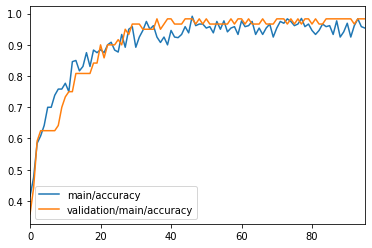

In [359]:
%matplotlib inline
results[['main/accuracy', 'validation/main/accuracy']].plot()

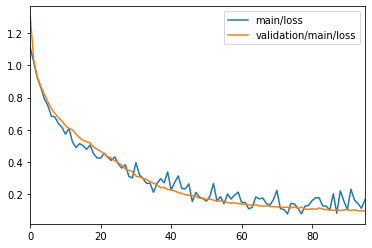

In [360]:
results[['main/loss', 'validation/main/loss']].plot()

# 実践問題
上記の問題設定にてハイパーパラメータの値などを変更し、精度が90%以上になるようなモデルを作成する

In [361]:
df.iloc[:, 1:].head() # パラメータにばらつきがある場合は、batch normalizationが有効

,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185
3,14.37,2.50,16.8,113,3.85,3.49,0.24,7.80,0.86,1480
4,13.24,2.87,21.0,118,2.80,2.69,0.39,4.32,1.04,735


In [362]:
model

# 学習済みモデルを保存

In [363]:
chainer.serializers.save_npz('models/wine.npz', model)

# 学習済みモデルを使用した推論

# 学習済みモデルのロード

In [364]:
model = L.Classifier(NN())

In [365]:
chainer.serializers.load_npz('models/wine.npz', model)

# 予測値の計算

In [369]:
x_new = x_new[np.newaxis]

In [370]:
x_new.shape

(1, 10)

In [371]:
# 予測値の計算
y = model.predictor(x_new)

C:\Users\haruk\Anaconda3\envs\ai-gpu\lib\site-packages\chainer\functions\normalization\batch_normalization.py:135: UserWarning: A batch with no more than one sample has been given to F.batch_normalization. F.batch_normalization will always output a zero tensor for such batches. This could be caused by incorrect configuration in your code (such as running evaluation while chainer.config.train=True), but could also happen in the last batch of training if non-repeating iterator is used.
  UserWarning)


In [372]:
y

variable([[-0.3450836 ,  0.34391862, -0.76520276]])

In [373]:
y = F.softmax(y)
y

variable([[0.27407053, 0.5458737 , 0.18005572]])

In [374]:
y.array

array([[0.27407053, 0.5458737 , 0.18005572]], dtype=float32)

In [375]:
np.argmax(y.array)

1